## Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

!gdown 1Gg562BH9hsh9qYxSnn6MqvUmpCIABpsr
!gdown 1qHUKjWfaUUJELetH655hadqZabG1AKFp
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv("ratings.csv")


Downloading...
From: https://drive.google.com/uc?id=1Gg562BH9hsh9qYxSnn6MqvUmpCIABpsr
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qHUKjWfaUUJELetH655hadqZabG1AKFp
To: /content/movies.csv
100% 494k/494k [00:00<00:00, 47.0MB/s]


## Data preprocessing

#### 1. Form the transactional data set, which consists of entries of the form ⟨user id, {movies rated above 2}⟩. Consider only those users who have rated more than 10 movies.


In [2]:
# 1
# Filter out the ratings less than or equal to 2
df_ratings = df_ratings[df_ratings["rating"] > 2]

# Group ratings by user and count how many movies each user has rated
user_movie_counts = df_ratings.groupby("userId")["movieId"].count()

# Select users who have rated more than 10 movies
valid_user_ids = user_movie_counts[user_movie_counts > 10].index

# Filter the dataset to include only valid users
df_ratings = df_ratings[df_ratings["userId"].isin(valid_user_ids)]


#### 2. Divide the data set into 80% training set and 20% test set. Remove 20% of movies watched from each user and create a test set using the removed movies.

In [3]:
# 2
train_set = {}
test_set = {}

# For each user, randomly remove 20% of the movies they rated and place them in the test set
train_movies, test_movies = train_test_split(df_ratings, test_size=0.2, random_state=42)

# for user_id, user_group in df_ratings.groupby("userId"):
    # movies_watched = list(user_group["movieId"])

    # # Randomly select 20% of movies to place in the test set
    # test_size = int(len(movies_watched) * 0.2)
    # test_movies = random.sample(movies_watched, test_size)

    # # Place the remaining 80% of movies in the training set
    # train_movies = list(set(movies_watched) - set(test_movies))

    # Use train_test_split to split 80% for training and 20% for testing
    # train_movies, test_movies = train_test_split(movies_watched, test_size=0.2, random_state=42)

    # train_set[user_id] = train_movies
    # test_set[user_id] = test_movies

for user_id, user_group in train_movies.groupby("userId"):
    train_set[user_id] = list(user_group["movieId"])

for user_id, user_group in test_movies.groupby("userId"):
    test_set[user_id] = list(user_group["movieId"])


# Create a list of all movies in the training set (with duplicates)
all_training_movies = [movie_id for user_id in train_set for movie_id in train_set[user_id]]

# Remove duplicates to get a unique list of movies in the training set
unique_training_movies = list(set(all_training_movies))


### Association Rule Mining
#### Part-1

##### 1. From the training set, extract the set of all association rules of form X → Y , where X contains a single movie and Y contains the set of movies from the training set by employing the apriori or FPgrowth approach. Set some minsup and minconf (e.g., 50 and 0.1 respectively).

In [4]:
# Define a function to calculate the support of a given set of movies
def calculate_support(movie_ids):
    # Find users who have watched all movies in the input set
    users_who_watched_all_movies = [
        user_id for user_id in train_set if all(movie_id in train_set[user_id] for movie_id in movie_ids)
    ]
    # Calculate the support as the fraction of users who have watched the movies
    return len(users_who_watched_all_movies) / len(train_set)

# # Function to generate frequent itemsets of a given size (2, 3, or 4) with a minimum support
# def find_frequent_itemsets(itemset_size, min_support, current_frequent_itemsets):
#     frequent_itemsets = []  # List to store frequent itemsets

#     # For pairs of movies (itemset_size == 2), generate all possible pairs
#     if itemset_size == 2:
#         candidate_itemsets = [(movie1, movie2) for movie1 in first_level_frequent_movies for movie2 in first_level_frequent_movies if movie1 < movie2]
#     else:
#         # For larger itemsets, generate new candidates by combining existing frequent itemsets
#         candidate_itemsets = []
#         for i in range(len(current_frequent_itemsets)):
#             for j in range(i + 1, len(current_frequent_itemsets)):
#                 # If all but the last movie in the itemsets are the same, merge to create a larger itemset
#                 if sorted(current_frequent_itemsets[i][:-1]) == sorted(current_frequent_itemsets[j][:-1]):
#                     new_candidate = list(current_frequent_itemsets[i][:-1])
#                     new_candidate.append(current_frequent_itemsets[i][-1])
#                     new_candidate.append(current_frequent_itemsets[j][-1])
#                     candidate_itemsets.append(new_candidate)

#     # Calculate the support of each candidate
#     for candidate_itemset in candidate_itemsets:
#         support_value = calculate_support(candidate_itemset)
#         # If support is above the minimum threshold, add to frequent itemsets
#         if support_value >= min_support:
#             frequent_itemsets.append(candidate_itemset)

#     return frequent_itemsets

# Function to generate association rules where X is a single movie
def generate_single_movie_association_rules(frequent_itemsets, min_confidence):
    association_rules = []  # List to store association rules
    for itemset in frequent_itemsets:
        itemset_support = calculate_support(itemset)  # Calculate support for the current itemset
        # Ensure that X contains only one movie, and the rest of the itemset is the right-hand side Y
        for movie in itemset:
            antecedent = [movie]  # Single movie on the left-hand side (X)
            consequent = list(set(itemset) - set(antecedent))  # Other movies on the right-hand side (Y)
            if consequent:
                confidence_value = itemset_support / calculate_support(antecedent)  # Calculate confidence
                # If confidence is above the minimum threshold, store the rule
                if confidence_value >= min_confidence:
                    association_rules.append([antecedent, consequent, itemset_support, confidence_value])

    return association_rules

In [5]:
# Set minimum support and confidence thresholds
min_support = 0.1
min_confidence = 0.1

# Calculate support for all individual movies
movies_with_min_support = {
    movie_id: calculate_support([movie_id])
    for movie_id in unique_training_movies
    if calculate_support([movie_id]) >= min_support
}

# Filter movies with support above the minimum threshold
movies_meeting_min_support = list(movies_with_min_support.keys())

first_level_frequent_movies = movies_meeting_min_support


In [6]:
# Function to generate frequent itemsets of a given size (2, 3, or 4) with a minimum support
def find_frequent_itemsets(itemset_size, min_support, current_frequent_itemsets):
    frequent_itemsets = []  # List to store frequent itemsets

    # For pairs of movies (itemset_size == 2), generate all possible pairs
    if itemset_size == 2:
        candidate_itemsets = [(movie1, movie2) for movie1 in first_level_frequent_movies for movie2 in first_level_frequent_movies if movie1 < movie2]
    else:
        # For larger itemsets, generate new candidates by combining existing frequent itemsets
        candidate_itemsets = []
        for i in range(len(current_frequent_itemsets)):
            for j in range(i + 1, len(current_frequent_itemsets)):
                # If all but the last movie in the itemsets are the same, merge to create a larger itemset
                if sorted(current_frequent_itemsets[i][:-1]) == sorted(current_frequent_itemsets[j][:-1]):
                    new_candidate = list(current_frequent_itemsets[i][:-1])
                    new_candidate.append(current_frequent_itemsets[i][-1])
                    new_candidate.append(current_frequent_itemsets[j][-1])
                    candidate_itemsets.append(new_candidate)

    # Calculate the support of each candidate
    for candidate_itemset in candidate_itemsets:
        support_value = calculate_support(candidate_itemset)
        # If support is above the minimum threshold, add to frequent itemsets
        if support_value >= min_support:
            frequent_itemsets.append(candidate_itemset)

    return frequent_itemsets

In [7]:
# Generate frequent itemsets of size 2, 3, and 4
second_level_frequent_itemsets = find_frequent_itemsets(2, min_support, first_level_frequent_movies)
third_level_frequent_itemsets = find_frequent_itemsets(3, min_support, second_level_frequent_itemsets)
fourth_level_frequent_itemsets = find_frequent_itemsets(4, min_support, third_level_frequent_itemsets)

# Generate association rules from the frequent itemsets
association_rules = []
association_rules += generate_single_movie_association_rules(second_level_frequent_itemsets, min_confidence)
association_rules += generate_single_movie_association_rules(third_level_frequent_itemsets, min_confidence)
association_rules += generate_single_movie_association_rules(fourth_level_frequent_itemsets, min_confidence)

# Now association rules will be of the form X → Y, where X contains a single movie and Y is the set of other movies.

### Part-2

#### 2. Recommendation: Generate two sets of lists:
##### • The initial list includes the top 100 association rules, arranged in order of their support.
##### • The second list comprises the top 100 rules, prioritizing them according to confidence.
##### • Identify the rules that appear in both lists, and then arrange these shared rules based on their confidence score.

In [8]:
# Sort the association rules by support (rule[2] is the support value)
sorted_by_support = sorted(association_rules, key=lambda x: x[2], reverse=True)

# Sort the association rules by confidence (rule[3] is the confidence value)
sorted_by_confidence = sorted(association_rules, key=lambda x: x[3], reverse=True)

# Select the top 100 rules based on support
top_100_by_support = sorted_by_support[:100]

# Select the top 100 rules based on confidence
top_100_by_confidence = sorted_by_confidence[:100]

# Find common rules that appear in both top 100 support and top 100 confidence lists
common_rules_in_both_lists = [
    rule_support for rule_support in top_100_by_support for rule_conf in top_100_by_confidence if rule_support == rule_conf
]

# Sort the common rules by confidence (rule[3] is the confidence value)
common_rules_in_both_lists = sorted(common_rules_in_both_lists, key=lambda x: x[3], reverse=True)

# Write the top 100 rules by support to a file
with open("62_top100RulesBySup.txt", "w") as support_file:
    for rule in top_100_by_support:
        support_file.write(",".join(map(str, rule)) + "\n")

# Write the top 100 rules by confidence to a file
with open("62_top100RulesByConf.txt", "w") as confidence_file:
    for rule in top_100_by_confidence:
        confidence_file.write(",".join(map(str, rule)) + "\n")

# Write the common rules (those that appeared in both support and confidence top 100 lists) to a file
with open("62_commonRulesByConfidence.txt", "w") as common_file:
    for rule in common_rules_in_both_lists:
        common_file.write(",".join(map(str, rule)) + "\n")

common_rules_in_both_lists

[[[7153], [4993], 0.18616144975288304, 0.7635135135135136],
 [[5952], [4993], 0.15980230642504117, 0.7519379844961239],
 [[1210], [260], 0.18616144975288304, 0.7337662337662338],
 [[1196], [260], 0.19604612850082373, 0.7300613496932515],
 [[4993], [7153], 0.18616144975288304, 0.7290322580645161],
 [[47], [296], 0.17957166392092258, 0.6855345911949685],
 [[2959], [2571], 0.18616144975288304, 0.6726190476190477],
 [[1210], [2571], 0.1696869851729819, 0.6688311688311689],
 [[1196], [2571], 0.17957166392092258, 0.6687116564417178],
 [[2028], [2571], 0.15980230642504117, 0.6643835616438356],
 [[1210], [1196], 0.16639209225700163, 0.6558441558441558],
 [[480], [356], 0.19769357495881384, 0.6557377049180327],
 [[7153], [2571], 0.15815485996705106, 0.6486486486486486],
 [[527], [318], 0.17298187808896212, 0.6441717791411044],
 [[4993], [2571], 0.1630971993410214, 0.6387096774193547],
 [[50], [318], 0.171334431630972, 0.6380368098159509]]

In [9]:
# @title Default title text
# # df_movies.head()
# #map movie id to title
# dic_movie_={}
# for i in range(len(df_movies)):
#     dic_movie_[int(df_movies.iloc[i]['movieId'])]=df_movies.iloc[i]['title']

# def write_to_file(list_of_tuples,file_name):
#     lst=["Rule , Support , Confidence \n"]

#     for rule in list_of_tuples:
#         rule_X=rule[0]
#         rule_Y=rule[1]
#         support=rule[2]
#         confidence=rule[3]
#         # lst_rules=rule.split('->')
#         # A=lst_rules[0]
#         # B=lst_rules[1][2:-1]
#         # B_lst=B.split(',')
#         # recommmended_movies=[dic_movie_[int(float(id))] for id in B_lst]
#         recommmended_movies=[dic_movie_[int(float(id))] for id in rule_Y]
#         reco_str=','.join(recommmended_movies)
#         # st=dic_movie_[int(float(A))]+"-> {"+reco_str+"} , "+str(support)+" , "+str(confidence)+" \n"
#         st=dic_movie_[int(float(rule_X[0]))]+"-> {"+reco_str+"} , "+str(support)+" , "+str(confidence)+" \n"
#         lst.append(st)
#     with open(file_name,'w') as f:
#         f.writelines(lst)

# write_to_file(top_100_sup_rules,'62_top100RulesBySup1.txt')
# write_to_file(top_100_conf_rules,'62_top100RulesByConf1.txt')
# write_to_file(shared_rules,'62_shared_rules1.txt')

In [10]:
# Function to write the association rules to a file using movie titles instead of IDs
def write_rules_to_file(list_of_rules, file_name):
    # Start with the header
    lines = ["Rule -> {Recommendation} , Support , Confidence\n"]

    # Iterate over each rule in the list
    for rule in list_of_rules:
        # Rule components: X (antecedent), Y (consequent), support, confidence
        antecedent = rule[0]
        consequent = rule[1]
        support = rule[2]
        confidence = rule[3]

        # Convert movie IDs in the antecedent (X) and consequent (Y) to movie titles
        recommended_movies = [movie_id_to_title[int(float(movie_id))] for movie_id in consequent]
        recommendation_str = ', '.join(recommended_movies)

        # Form the rule string, mapping the antecedent movie ID to its title
        rule_str = f"{movie_id_to_title[int(float(antecedent[0]))]} -> {{{recommendation_str}}} , {support} , {confidence}\n"

        # Append the rule to the lines list
        lines.append(rule_str)

    # Write all lines to the specified file
    with open(file_name, 'w') as file:
        file.writelines(lines)

# Map movie IDs to movie titles
movie_id_to_title = {
    int(df_movies.iloc[i]['movieId']): df_movies.iloc[i]['title'] for i in range(len(df_movies))
}

# Write the top 100 rules by support to a file
write_rules_to_file(top_100_by_support, 'top100_rules_by_support_with_titles.txt')

# Write the top 100 rules by confidence to a file
write_rules_to_file(top_100_by_confidence, 'top100_rules_by_confidence_with_titles.txt')

# Write the common rules to a file
write_rules_to_file(common_rules_in_both_lists, 'common_rules_with_titles.txt')


### Part-3

##### 3. For each user in the test set, select association rules of the form X → Y , where X is the movie in the training set. Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs.

In [11]:
# Initialize lists to store the average precision and recall values for each value of k
average_precision_list = []
average_recall_list = []

# Initialize the sums for precision and recall for the current number of rules
total_recall_sum = 0
total_precision_sum = 0

# Loop over the number of rules to consider (1 to 10)

for num_rules in range(1, 11):
    print(f"Evaluating for {num_rules} rules : ")

    # Initialize the sums for precision and recall for the current number of rules
    # total_recall_sum = 0
    # total_precision_sum = 0

    # Loop over each user in the training set
    for user in tqdm(train_set):
        # # Initialize the sums for precision and recall for the current number of rules
        total_recall_sum = 0
        total_precision_sum = 0

        # Get the movies watched by the user in the training set
        train_movies = train_set[user]

        # If the user is in the test set, compute precision and recall
        if user in test_set:

            test_movies = test_set[user]

            # Initialize lists to store recommendations and hits
            recommended_movies = []
            hits = []

            # Generate recommendations for the user based on association rules
            for movie_in_train in train_movies:
                recommended_for_movie = []
                rule_count = 0

                # Find association rules where the antecedent (X) is the movie in the training set
                for rule in sorted_by_confidence:
                    if int(rule[0][0]) == int(movie_in_train):
                        recommended_for_movie += rule[1]  # Add consequent (Y) to the recommendations
                        rule_count += 1
                        if rule_count == num_rules:  # Stop once we have 'num_rules' recommendations
                            break

                # Add all recommendations to the overall recommendation list for this user
                recommended_movies += recommended_for_movie

            # Find the hits (movies in the recommendation list that are also in the test set)
            hits = [movie for movie in recommended_movies if movie in test_movies]

            # Calculate recall: Hits / Total relevant items (movies in the test set)
            if len(test_movies) > 0:
                recall = len(hits) / len(test_movies)
            else:
                recall = 0

            # Calculate precision: Hits / Total recommended items (if any recommendations were made)
            if len(recommended_movies) > 0:
                precision = len(hits) / len(recommended_movies)
            else:
                precision = 0

            # Accumulate recall and precision for this user
            total_recall_sum += recall
            total_precision_sum += precision

    # Compute average recall and precision for the current value of 'num_rules'
    average_recall = total_recall_sum / len(train_set)
    average_precision = total_precision_sum / len(train_set)

    # Append the results to the respective lists
    average_precision_list.append(average_precision)
    average_recall_list.append(average_recall)

# Print the precision and recall averages
print('\n\n')
print("Precision Averages:", average_precision_list)
print("Recall Averages:", average_recall_list)




Evaluating for 1 rules : 


100%|██████████| 607/607 [00:30<00:00, 19.85it/s]


Evaluating for 2 rules : 


100%|██████████| 607/607 [00:30<00:00, 20.22it/s]


Evaluating for 3 rules : 


100%|██████████| 607/607 [00:31<00:00, 19.47it/s]


Evaluating for 4 rules : 


100%|██████████| 607/607 [00:33<00:00, 18.34it/s]


Evaluating for 5 rules : 


100%|██████████| 607/607 [00:30<00:00, 19.68it/s]


Evaluating for 6 rules : 


100%|██████████| 607/607 [00:32<00:00, 18.59it/s]


Evaluating for 7 rules : 


100%|██████████| 607/607 [00:31<00:00, 19.44it/s]


Evaluating for 8 rules : 


100%|██████████| 607/607 [00:32<00:00, 18.80it/s]


Evaluating for 9 rules : 


100%|██████████| 607/607 [00:32<00:00, 18.62it/s]


Evaluating for 10 rules : 


100%|██████████| 607/607 [00:31<00:00, 19.05it/s]




Precision Averages: [0.0005766062602965403, 0.0006085162592576102, 0.0005077036254183374, 0.00045807047856310525, 0.0004353008933713719, 0.00040463597213792304, 0.00041823718128541627, 0.00040270913417536153, 0.0003856617662470499, 0.0003810682227593958]
Recall Averages: [0.00014296022982558852, 0.0002791128296594823, 0.00033357386959303987, 0.0003880349095265974, 0.0004424959494601549, 0.00047653409941862836, 0.0005582256593189646, 0.0005990714392691329, 0.0006263019592359116, 0.0006739553691777745]


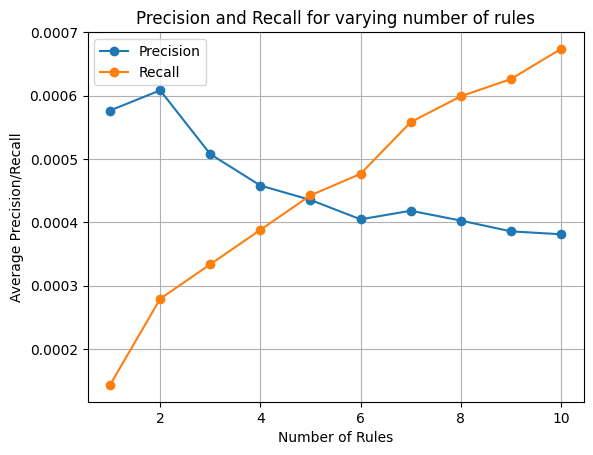

In [12]:
# Plot precision and recall against the number of rules (1 to 10)
x_values = [i for i in range(1, 11)]
plt.plot(x_values, average_precision_list, label="Precision", marker='o')
plt.plot(x_values, average_recall_list, label="Recall", marker='o')

# Add labels and legend to the plot
plt.xlabel("Number of Rules")
plt.ylabel("Average Precision/Recall")
plt.title("Precision and Recall for varying number of rules")
plt.legend()
plt.grid(True)
plt.show()

Decreasing Precision: On increasing the number of rules (k), the average precision is likely to decrease. This is because with more rules, we are recommending a larger set of items, and some of those recommendations may not be relevant to the user. As a result, the precision, which measures how many of the recommended items are relevant, tends to decrease as k increases.

Increasing Recall: On the other handOn increasing the number of rules (e) N, the average recall is likely to increase. This is because with more rulesweou are recommending a larger set of items, which is more likely to include some of the relevant items from the test set. Recall measures how many of the relevant items are included in the recommendations, and aweou provide more recommendationsweou are more likely to cover a larger portion of the relevant items.

Trade-off Between Precision and Recall: The graph will likely show a trade-off between precision and recall. Wwe you have fewer rules (loker we you have a higher precision but a lower recall, and wwe you have more rules (higker we you have a higher recall but a lower precisces.

### Part-4
##### 4. Take a sample example of users and their movie ratings from the test set and display precision and recall graphs.

In [13]:
# @title Default title text
# sample_size = 20
# sample_users = random.sample(list(test_set.keys()), sample_size)

# precision_avgs = []
# recall_avgs = []

# for k in range(1, 11):
#     recall_sum = 0
#     precision_sum = 0

#     for user in sample_users:
#         train = train_set[user]
#         if user in test_set:
#             test = test_set[user]
#             recommendation = []

#             for x in train:
#                 y = []
#                 count = 0
#                 for asr in conf_rules:
#                     if int(asr[0][0]) == int(x):
#                         y = y + asr[1]
#                         count += 1
#                         if count == k:
#                             break
#                 recommendation = recommendation + y

#             hit_set = [m for m in recommendation if m in test]

#             recall = len(hit_set) / len(test)
#             precision = (
#                 len(hit_set) / len(recommendation) if len(recommendation) > 0 else 0
#             )

#             recall_sum += recall
#             precision_sum += precision

#     recall_avg = recall_sum / sample_size
#     precision_avg = precision_sum / sample_size

#     precision_avgs.append(precision_avg)
#     recall_avgs.append(recall_avg)

# x = [i for i in range(1, 11)]
# plt.plot(x, precision_avgs, label="precision")
# plt.plot(x, recall_avgs, label="recall")
# plt.legend()
# plt.xlabel("k")
# plt.ylabel("Score")
# plt.title("Precision and Recall vs. k")
# plt.show()




In [14]:
# @title Default title text
# users_per_row = 5
# num_rows = (sample_size + users_per_row - 1) // users_per_row

# for row in range(num_rows):
#     plt.figure(figsize=(25, 5))

#     for col in range(users_per_row):
#         index = row * users_per_row + col
#         if index >= sample_size:
#             break

#         user = sample_users[index]
#         precision_avgs = []
#         recall_avgs = []

#         for k in range(1, 11):
#             train = train_set[user]
#             if user in test_set:
#                 test = test_set[user]
#                 recall_sum = 0
#                 precision_sum = 0
#                 recommendation = []

#                 for x in train:
#                     y = []
#                     count = 0
#                     for asr in conf_rules:
#                         if int(asr[0][0]) == int(x):
#                             y = y + asr[1]
#                             count += 1
#                             if count == k:
#                                 break
#                     recommendation = recommendation + y

#                 hit_set = [m for m in recommendation if m in test]

#                 recall = len(hit_set) / len(test)
#                 precision = (
#                     len(hit_set) / len(recommendation) if len(recommendation) > 0 else 0
#                 )

#                 recall_sum += recall
#                 precision_sum += precision

#             recall_avg = recall_sum
#             precision_avg = precision_sum

#             precision_avgs.append(precision_avg)
#             recall_avgs.append(recall_avg)

#         x = [i for i in range(1, 11)]
#         plt.subplot(1, users_per_row, col + 1)
#         plt.plot(x, precision_avgs, label="precision")
#         plt.plot(x, recall_avgs, label="recall")
#         plt.xlabel("k")
#         plt.ylabel("Score")
#         plt.title(f"User {user}")
#         plt.legend()

#     plt.show()


100%|██████████| 16/16 [00:00<00:00, 36.58it/s]


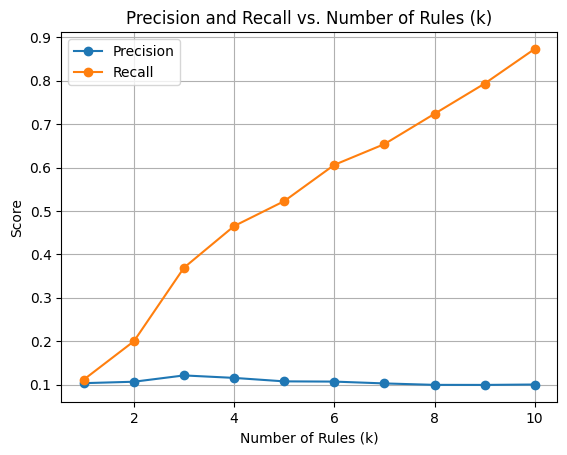

In [35]:
# Number of sample users to consider from the test set
sample_size = 16

# Randomly select a sample of users from the test set
sample_users = random.sample(list(test_set.keys()), sample_size)

# Lists to store the average precision and recall for different values of k (1 to 10)
average_precision_list = []
average_recall_list = []

# Loop over different values of k (number of rules to consider)
for num_rules in range(1, 11):
    # Initialize sums for precision and recall for the current k
    total_recall_sum = 0
    total_precision_sum = 0

    # Loop through each user in the sample of users
    for user in tqdm(sample_users):
        # Get the movies watched by the user in the training set
        user_train_movies = train_set[user]

        # If the user has test data (movies in the test set)
        if user in test_set:
            user_test_movies = test_set[user]

            # Initialize list to store recommended movies
            recommended_movies = []

            # Generate recommendations for each movie the user has seen in the training set
            for movie_in_train in user_train_movies:
                movie_recommendations = []
                rule_count = 0

                # Find association rules where the antecedent (X) is the movie the user watched
                for rule in sorted_by_confidence:
                    if int(rule[0][0]) == int(movie_in_train):
                        # Add the consequents (Y) to the list of recommendations
                        movie_recommendations += rule[1]
                        rule_count += 1
                        # Stop once we have considered 'num_rules' recommendations
                        if rule_count == num_rules:
                            break

                # Add the movie recommendations for this movie to the overall list of recommendations
                recommended_movies += movie_recommendations

            # Find the movies that were recommended and also appear in the user's test set (hits)
            hits = [movie for movie in recommended_movies if movie in user_test_movies]

            # Calculate recall: Hits / Total relevant items (movies in the test set)
            if len(user_test_movies) > 0:
                recall = len(hits) / len(user_test_movies)
            else:
                recall = 0

            # Calculate precision: Hits / Total recommended items (if any recommendations were made)
            if len(recommended_movies) > 0:
                precision = len(hits) / len(recommended_movies)
            else:
                precision = 0

            # Accumulate recall and precision for this user
            total_recall_sum += recall
            total_precision_sum += precision

    # Compute average recall and precision for the current value of 'num_rules'
    average_recall = total_recall_sum / sample_size
    average_precision = total_precision_sum / sample_size

    # Append the results to the respective lists
    average_precision_list.append(average_precision)
    average_recall_list.append(average_recall)

# Plot precision and recall against the number of rules (1 to 10)
x_values = [i for i in range(1, 11)]
plt.plot(x_values, average_precision_list, label="Precision", marker='o')
plt.plot(x_values, average_recall_list, label="Recall", marker='o')

# Add labels, title, and legend to the plot
plt.xlabel("Number of Rules (k)")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Number of Rules (k)")
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 10/10 [00:00<00:00, 174.16it/s]


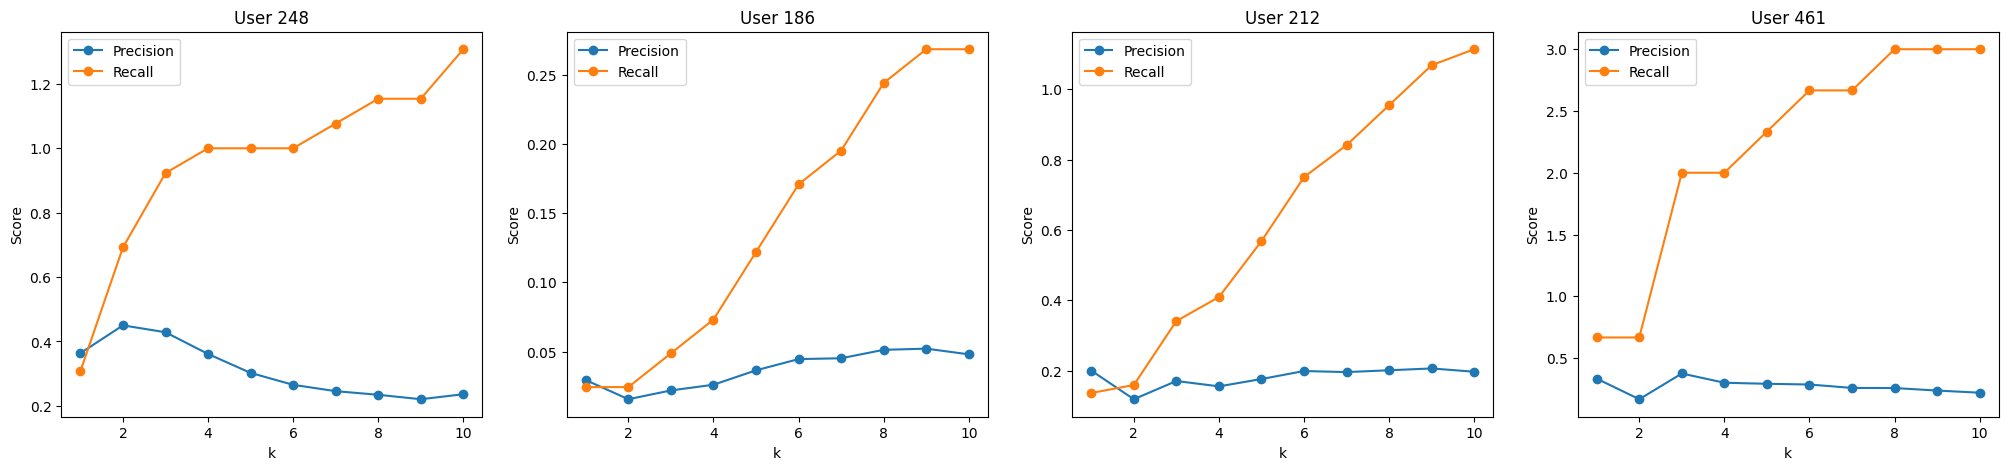

100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


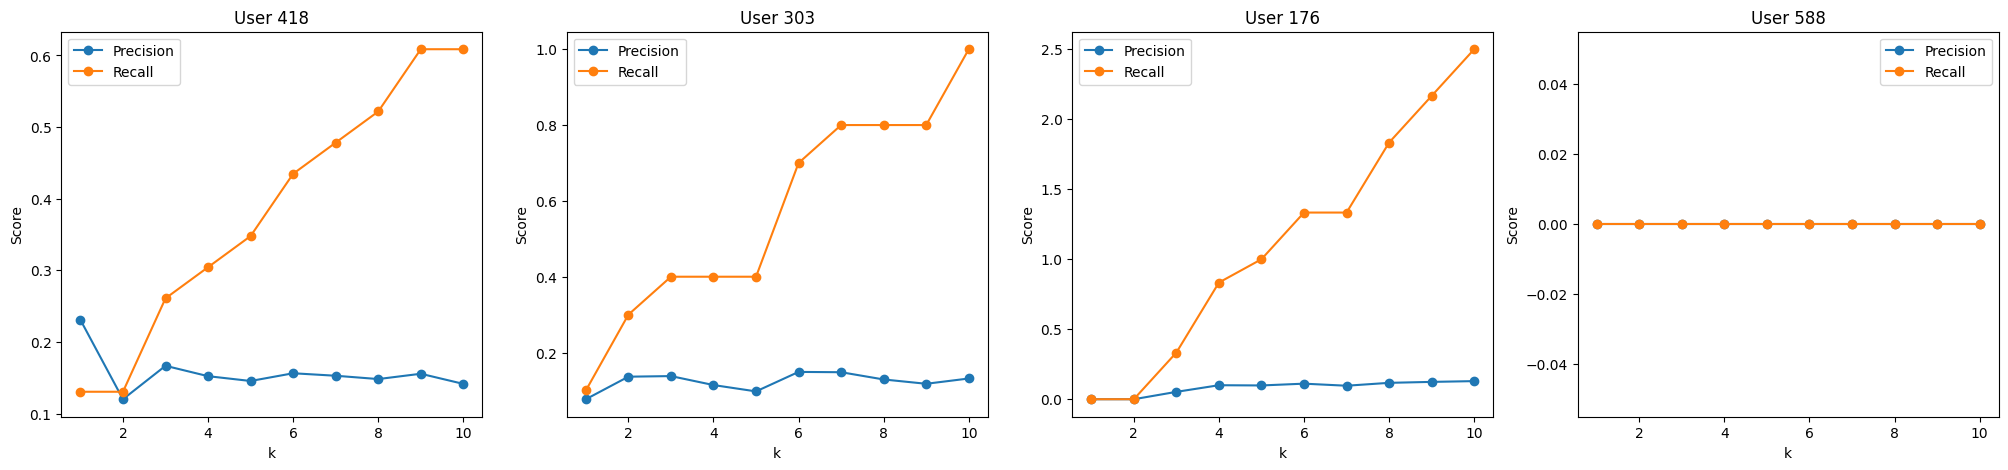

100%|██████████| 10/10 [00:00<00:00, 52.40it/s]


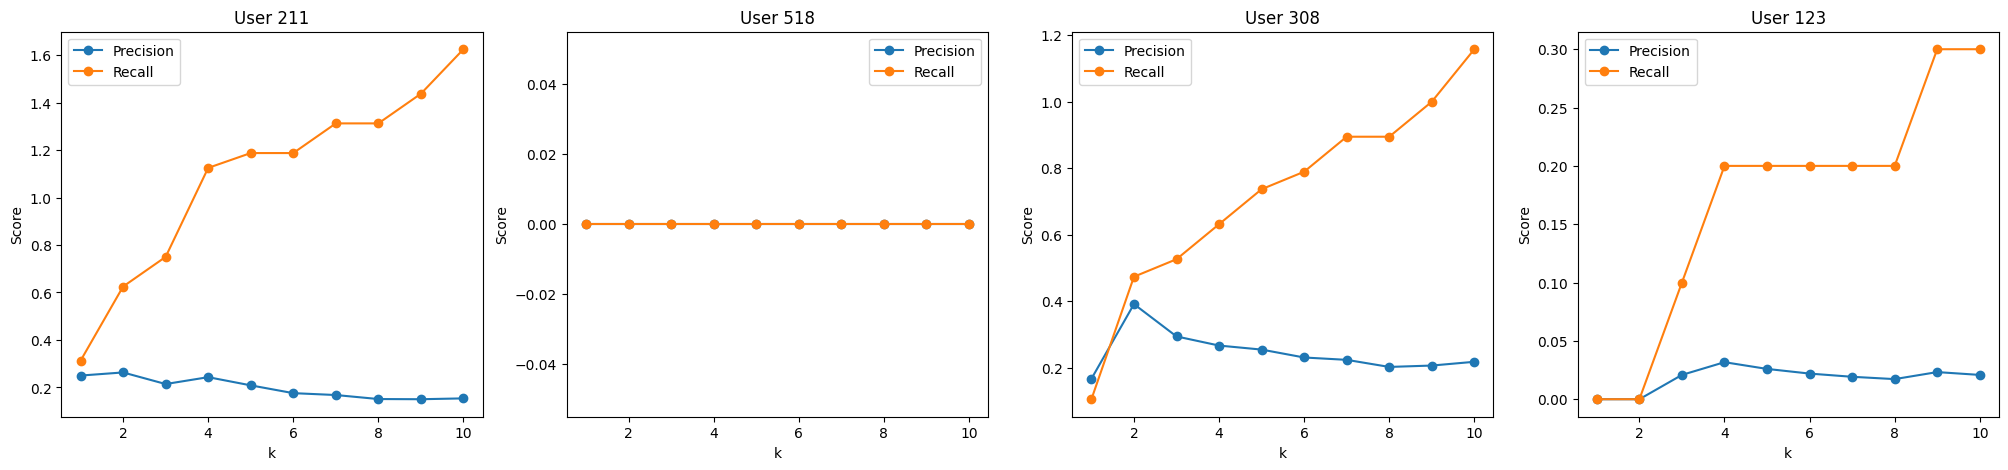

100%|██████████| 10/10 [00:00<00:00, 32.72it/s]


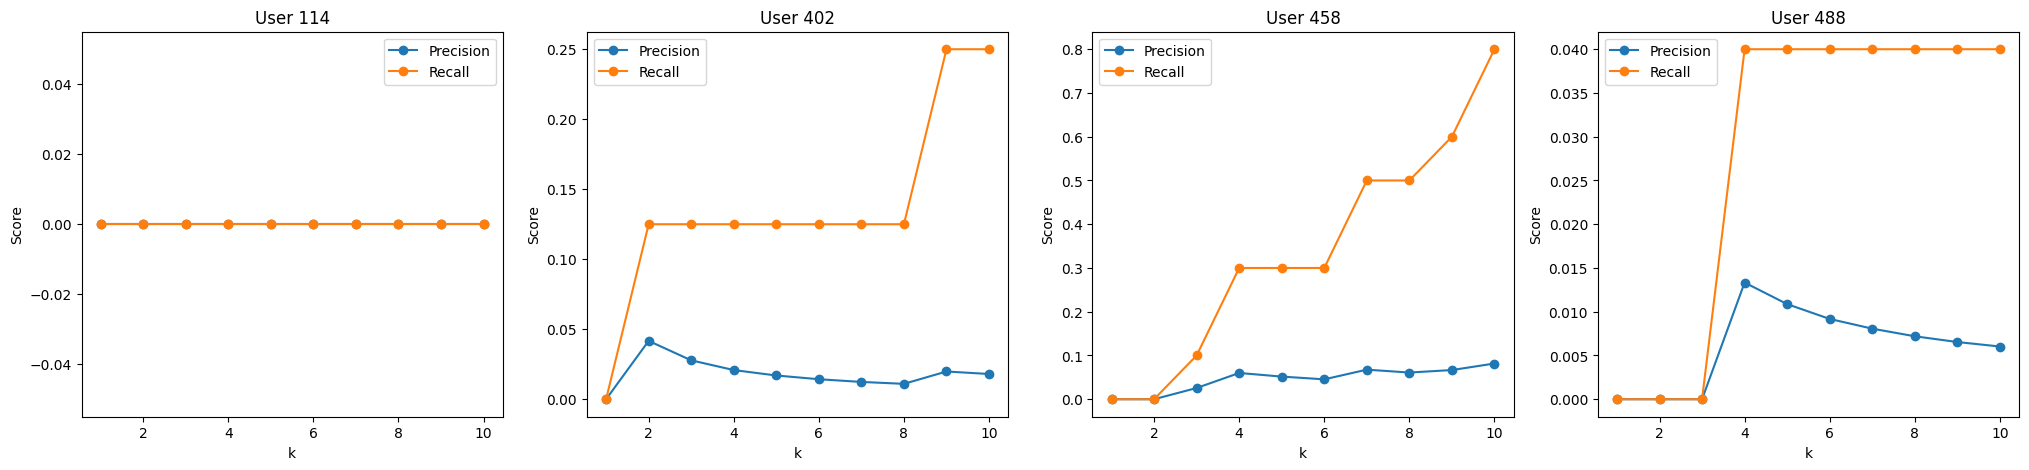

In [36]:
# Number of users to plot per row
users_per_row = 4

# Calculate number of rows needed based on sample size and users per row
num_rows = (sample_size + users_per_row - 1) // users_per_row

# Loop through each row
for row in range(num_rows):
    plt.figure(figsize=(25, 5))  # Set figure size for each row of plots

    # Loop through columns in the current row
    for col in range(users_per_row):
        index = row * users_per_row + col  # Calculate user index
        if index >= sample_size:  # If index exceeds the sample size, break
            break

        # Get the user at the current index
        user = sample_users[index]

        # Lists to store precision and recall values for this user
        precision_values = []
        recall_values = []

        # Loop over different values of k (number of rules to consider)
        for num_rules in tqdm(range(1, 11)):
            # Get the training data (movies watched) for the current user
            user_train_movies = train_set[user]

            # Initialize sums for recall and precision
            total_recall = 0
            total_precision = 0

            # Check if the user has a test set (movies in the test set)
            if user in test_set:
                user_test_movies = test_set[user]

                # List to store the recommended movies
                recommended_movies = []

                # Generate recommendations for each movie in the user's training set
                for movie_in_train in user_train_movies:
                    movie_recommendations = []
                    rule_count = 0

                    # Find association rules where the antecedent (X) is the movie the user watched
                    for rule in sorted_by_confidence:
                        if int(rule[0][0]) == int(movie_in_train):
                            # Add the consequents (Y) to the recommendation list
                            movie_recommendations += rule[1]
                            rule_count += 1
                            # Stop once we have considered 'num_rules' recommendations
                            if rule_count == num_rules:
                                break

                    # Add recommendations for this movie to the overall recommendations
                    recommended_movies += movie_recommendations

                # Calculate hits (movies in both recommendations and test set)
                hits = [movie for movie in recommended_movies if movie in user_test_movies]

                # Calculate recall: Hits / Total relevant items (movies in the test set)
                recall = len(hits) / len(user_test_movies) if len(user_test_movies) > 0 else 0

                # Calculate precision: Hits / Total recommended items (if recommendations were made)
                precision = len(hits) / len(recommended_movies) if len(recommended_movies) > 0 else 0

                # Add the recall and precision for the current value of 'num_rules'
                total_recall += recall
                total_precision += precision

            # Append the average recall and precision for the current value of 'num_rules'
            recall_values.append(total_recall)
            precision_values.append(total_precision)

        # Create the plot for the current user
        x_values = [i for i in range(1, 11)]  # Values of k (1 to 10)
        plt.subplot(1, users_per_row, col + 1)  # Create a subplot in the current row
        plt.plot(x_values, precision_values, label="Precision", marker='o')
        plt.plot(x_values, recall_values, label="Recall", marker='o')

        # Add labels, title, and legend for each user's plot
        plt.xlabel("k")
        plt.ylabel("Score")
        plt.title(f"User {user}")
        plt.legend()

    # Show the plot for the current row of users
    plt.show()
    print()
